In [3]:
import cv2
img = cv2.imread('./car.jpg')

ret, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)  # binary （黑白二值）

ret, thresh2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)  # （黑白二值反转）

ret, thresh3 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)  # 得到的图像为多像素值

ret, thresh4 = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO)  # 高于阈值时像素设置为255，低于阈值时不作处理

ret, thresh5 = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO_INV)  # 低于阈值时设置为255，高于阈值时不作处理

print(ret)

cv2.imshow('thresh1', thresh1)

cv2.imshow('thresh2', thresh2)

cv2.imshow('thresh3', thresh3)

cv2.imshow('thresh4', thresh4)

cv2.imshow('thresh5', thresh5)

cv2.imshow('grey-map', img)

cv2.waitKey(0)

cv2.destroyAllWindows()


127.0


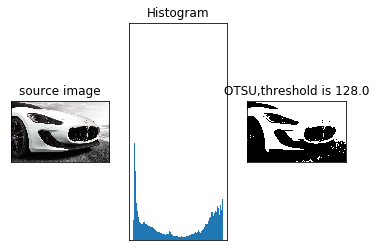

In [10]:
#coding:utf-8
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread('./car.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.subplot(131), plt.imshow(image, "gray")
plt.title("source image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.hist(image.ravel(), 256)
plt.title("Histogram"), plt.xticks([]), plt.yticks([])
ret1, th1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)  #方法选择为THRESH_OTSU
plt.subplot(133), plt.imshow(th1, "gray")
plt.title("OTSU,threshold is " + str(ret1)), plt.xticks([]), plt.yticks([])
plt.show()


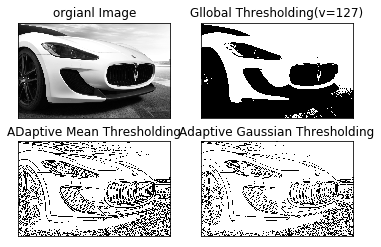

In [12]:
import cv2   
import numpy as np   
from matplotlib import pyplot as plt 

img = cv2.imread('./car.jpg',0)
img = cv2.medianBlur(img,5)
ret,th1 = cv2.threshold(img,110,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

titles = ['orgianl Image','Gllobal Thresholding(v=127)','ADaptive Mean Thresholding','Adaptive Gaussian Thresholding']
images = [img,th1,th2,th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()



In [14]:
#coding:utf-8
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random


#将不足8*m位的染色体扩展为8*m位
def expand(k, m):
    for i in range(len(k)):
        k[i] = k[i][:2] + '0'*(8*m+2 - len(k[i])) + k[i][2:len(k[i])]
    return k


def Hist(image):
    a=[0]*256
    h=image.shape[0]
    w=image.shape[1]
    MN=h*w
    average=0.0
    for i in range(w):
        for j in range(h):
            pixel=int(image[j][i])
            a[pixel]=a[pixel]+1
    for i in range(256):
        a[i]=a[i]/float(MN)
        average=average+a[i]*i
    return a, average


#解析多阈值基因串
def getTh(seed, m):
    th = [0, 256]
    seedInt = long(seed, 2)
    for i in range(0, m):
        tmp = seedInt & 255
        if tmp != 0:
            th.append(tmp)
        seedInt = seedInt >> 8
    th.sort()
    return th


#适应度函数 Ostu全局算法
def fitness(seed, p, average, m):
    Var = [0.0] * len(seed)
    g_muT = 0.0

    for i in range(256):
        g_muT = g_muT + i * p[i]

    for i in range(len(seed)):
        th = getTh(seed[i], m)
        for j in range(len(th)-1):
            w = [0.0] * (len(th)-1)
            muT = [0.0] * (len(th)-1)
            mu = [0.0] * (len(th)-1)
            for k in range(th[j], th[j+1]):
                w[j] = w[j] + p[k]
                muT[j] = muT[j] +  + p[k] * k
            if w[j] > 0:
                mu[j] = muT[j] / w[j]
                Var[i] = Var[i] + w[j] * pow(mu[j] - g_muT, 2)
    return Var


#选择算子 轮盘赌选择算法
def wheel_selection(seed, Var):
    var = [0.0]*len(Var)
    s = 0.0
    n = ['']*len(seed)
    sumV = sum(Var)
    for i in range(len(Var)):
        var[i] = Var[i]/sumV
    for i in range(1, len(Var)):
        var[i] = var[i] + var[i-1]
    for i in range(len(seed)):
        s = random.random()
        for j in range(len(var)):
            if s <= var[j]:
                n[i] = seed[j]
    return n


#单点交叉算子
def Cross(Next, m):
    for i in range(0, len(Next) - 1, 2):
        if random.random() < 0.7:
            if m > 2:
                tmp = Next[i][10:]
                Next[i] = Next[i][:10] + Next[i+1][10:]
                Next[i+1] = Next[i+1][:10] + tmp
            else:
                tmp = Next[i][6:]
                Next[i] = Next[i][:6] + Next[i+1][6:]
                Next[i+1] = Next[i+1][:6] + tmp
    return Next


#变异算子
def Variation(Next):
   for i in range(len(Next)):
        if random.random()<0.06:
            Next[i]=bin(long(Next[i],2)+2)
   return Next


#多阈值分割
def genetic_thres(image, k, m):
    th = image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for t in range(1, len(k)-1):
                if k[t-1] <= image[i][j] < k[t]:
                    th[i][j] = int(k[t-1])
    return th


# main
imagesrc = cv2.imread("E:/python/cv/OTSU/test2.jpg")
gray = cv2.cvtColor(imagesrc, cv2.COLOR_BGR2GRAY)

m = 3  #阈值数
items_x = range(0, imagesrc.shape[0])
items_y = range(0, imagesrc.shape[1])
random.shuffle(items_x)
random.shuffle(items_y)
x = items_x[0:20*m]  #产生随机x坐标
y = items_y[0:20*m]  #产生随机y坐标
seed = []
Var = 0.0
times = 0
k = 0
P, average = Hist(gray)  #计算直方图，P为各灰度的概率的数组，average为均值
for i in range(0, 20):
    code = long(0)
    for j in range(0, m):
        code = code + gray[x[i*j]][y[i*j]] << j*8  #将阈值连起来组成一个8*m比特的基因串
    seed.append(bin(code))  #生成第一代

while times < 2000:
    Var = fitness(seed, P, average, m)
    Next = wheel_selection(seed, Var)
    Next = Cross(Next, m)
    Next = expand(Variation(Next), m)
    seed = Next
    times = times + 1

for j in range(len(Var)):
    if Var[j] == max(Var):
        k = getTh(Next[j], m)
#print k

plt.subplot(131), plt.imshow(imagesrc, "gray")
plt.title("source image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.hist(imagesrc.ravel(), 256)
plt.title("Histogram"), plt.xticks([]), plt.yticks([])
th1 = genetic_thres(gray, k, m)
plt.subplot(133), plt.imshow(th1, "gray")
titleName = ''
for i in range(1, len(k)-1):
    titleName = titleName + str(k[i]) + ', '
titleName = titleName[:len(titleName)-2]
plt.title("threshold is " + titleName), plt.xticks([]), plt.yticks([])
plt.show()


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
